In [151]:
# 1D simulation with Particle-in-Cell
using Revise
import Random
Random.seed!(0)
cd("/Users/bach/OneDrive - Politechnika Warszawska/projects/2019/iskra")
include("problem/configuration.jl")
include("problem/units_and_constants.jl")
config = Config()
############################################
νtherm = 3e4
νdrift = 1e7
nO = 1e24
ne = nO
f  = 9kHz
ω  = 2π * f * sqrt(2e-6ne)
ds = 5e-3c0/ω
ts = 200
nx = 256
Δh =  ds

simulationVolume = nx * Δh
numCells         = nx
electronParticles    = 20 * numCells
totalNumElectrons    = ne * simulationVolume
electronNumRatio     = totalNumElectrons / electronParticles
Δt = .3Δh/νdrift
Lx = nx*Δh
############################################
println("Δt: ", Δt, "\nΔh: ", Δh, "\nLx: ", Lx)
println("νtherm: ", νtherm, "\nνdrift: ", νdrift)
println("electrons: ", electronParticles, " wg: ", electronNumRatio)

Δt: 5.623084195796749e-16
Δh: 1.8743613985989163e-8
Lx: 4.798365180413226e-6
νtherm: 30000.0
νdrift: 1.0e7
electrons: 5120 wg: 9.371806992994582e14


In [152]:
xs = 0m:Δh:Lx
#e₊ = create_kinetic_species("e- (v+)", 20_000,-1qe, 1me, 8e7; D=1);
#e₋ = create_kinetic_species("e- (v-)", 20_000,-1qe, 1me, 8e7; D=1);
e  = create_kinetic_species("e-",      20_000,-1qe, 1me, electronNumRatio; D=1);
iO = FluidSpecies("O+", 1.0, +1qe, 8mp, nO*ones(nx+1), 0.0K)

fwd = create_thermalized_beam(e, [Lx], [+νdrift 0 0]; T=0K, rate=electronParticles/2/Δt)
rev = create_thermalized_beam(e, [Lx], [-νdrift 0 0]; T=0K, rate=electronParticles/2/Δt)
using RegularGrid, FiniteDifferenceMethod, ParticleInCell
config.grid    = create_uniform_grid(xs)
config.cells   = create_staggered_grid(config.grid)
config.solver  = create_poisson_solver(config.grid, ε0)
config.pusher  = create_boris_pusher()
config.species = [e, iO]
############################################
nx, = size(config.grid)
mx, = size(config.cells)
εr  = ones(mx, 2)
bcs = zeros(Int8, nx)
bcs[ 1] = 1
bcs[nx] = 2
set_permittivity(εr)
apply_periodic(config.solver)
#apply_dirichlet(config.solver, bcs .== 1, 0.0)
#apply_dirichlet(config.solver, bcs .== 2, 0.0)
############################################
using ParticleInCell
using Diagnostics
using XDMF
using Diagnostics

function ParticleInCell.after_loop(i, t, dt)
  cd("/tmp")
  new_iteration("13_two-streams", i, t, dt) do it
    #save_records(it, "e- (v+)/")
    #save_records(it, "e- (v-)/")
    save_records(it, "e-/")
    save_record(it, "rho")
    save_record(it, "phi")
    save_record(it, "E")
    save_record(it, "nO+")
    save_record(it, "ne-")
  end
end

init(fwd, e, Δt)
init(rev, e, Δt)
@time solve(config, Δt, ts)

Time Step #1
Time Step #2
Time Step #3
Time Step #4
Time Step #5
Time Step #6
Time Step #7
Time Step #8
Time Step #9
Time Step #10
Time Step #11
Time Step #12
Time Step #13
Time Step #14
Time Step #15
Time Step #16
Time Step #17
Time Step #18
Time Step #19
Time Step #20
Time Step #21
Time Step #22
Time Step #23
Time Step #24
Time Step #25
Time Step #26
Time Step #27
Time Step #28
Time Step #29
Time Step #30
Time Step #31
Time Step #32
Time Step #33
Time Step #34
Time Step #35
Time Step #36
Time Step #37
Time Step #38
Time Step #39
Time Step #40
Time Step #41
Time Step #42
Time Step #43
Time Step #44
Time Step #45
Time Step #46
Time Step #47
Time Step #48
Time Step #49
Time Step #50
Time Step #51
Time Step #52
Time Step #53
Time Step #54
Time Step #55
Time Step #56
Time Step #57
Time Step #58
Time Step #59
Time Step #60
Time Step #61
Time Step #62
Time Step #63
Time Step #64
Time Step #65
Time Step #66
Time Step #67
Time Step #68
Time Step #69
Time Step #70
Time Step #71
Time Step #72
T

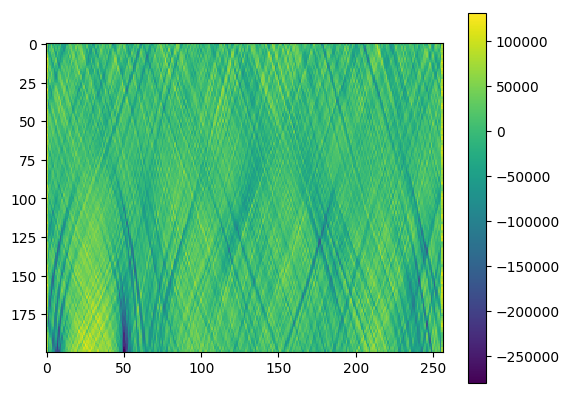

(1.8402736747906335e23, 2.7418733683379867e24)


PyObject <matplotlib.colorbar.Colorbar object at 0x1468840d0>

In [153]:
# Visualization of Particle-in-Cell results
using PyPlot
using PyCall
ov = pyimport("openpmd_viewer")
ts = ov.OpenPMDTimeSeries("/tmp/13_two-streams/hdf5")
pt = ov.ParticleTracker(ts, iteration=1, select=Dict("id"=>[0,electronParticles]),
    species="e-", preserve_particle_index=false)
it, np = length(ts.iterations), pt.N_selected;
nx = 257
px = zeros(it, np)
py = zeros(it, np)
vx = zeros(it, np)
vy = zeros(it, np)
Ex = zeros(it, nx)
phi = zeros(it, nx)
rho = zeros(it, nx)
nO  = zeros(it, nx)
ne  = zeros(it, nx)
for i=1:it
    x, y, ux, uy = ts.get_particle( ["x", "y", "ux", "uy"],
        select=pt, iteration=ts.iterations[i], species="e-")
    px[i, :] = x[:]
    py[i, :] = y[:]
    vx[i, :] = ux[:]
    vy[i, :] = uy[:]
    Ex[i, :],= ts.get_field("E", iteration=ts.iterations[i], coord="x")
   phi[i, :],= ts.get_field("phi", iteration=ts.iterations[i])
   rho[i, :],= ts.get_field("rho", iteration=ts.iterations[i])
    nO[i, :],= ts.get_field("nO+", iteration=ts.iterations[i])
    ne[i, :],= ts.get_field("ne-", iteration=ts.iterations[i])
end

println(extrema(ne))
imshow(rho); colorbar()

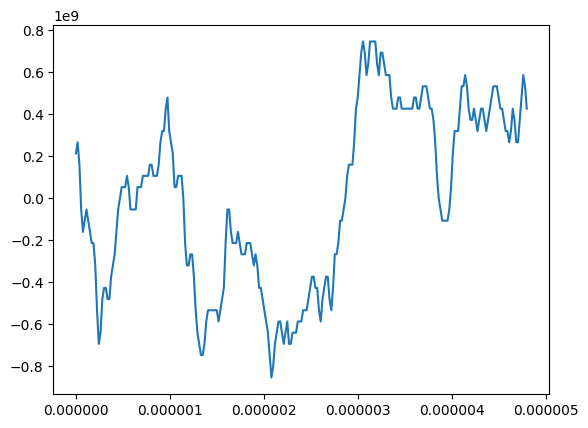

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1468d9550>

In [154]:
plot(xs, Ex[1,:])

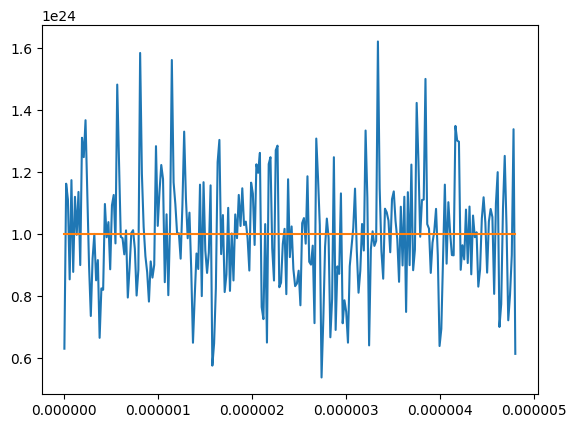

2-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1469565d0>
 PyObject <matplotlib.lines.Line2D object at 0x146992390>

In [155]:
plot(xs, ne[1,:], xs, nO[1,:])
#plot(xs, 1e-5rho[1,:])

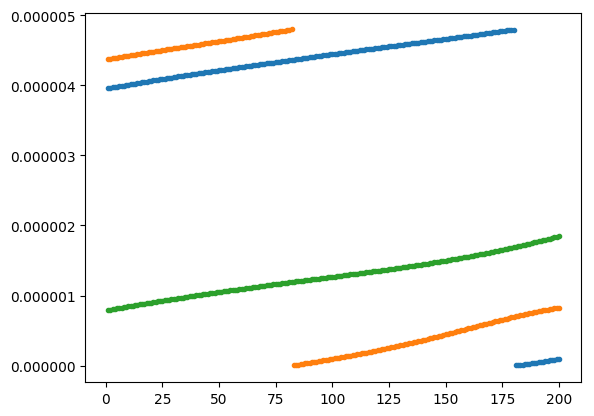

3-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x146998710>
 PyObject <matplotlib.lines.Line2D object at 0x1469fc2d0>
 PyObject <matplotlib.lines.Line2D object at 0x146998810>

In [156]:
plot(ts.iterations, px[:,1], ".",
     ts.iterations, px[:,2], ".",
     ts.iterations, px[:,3], ".")

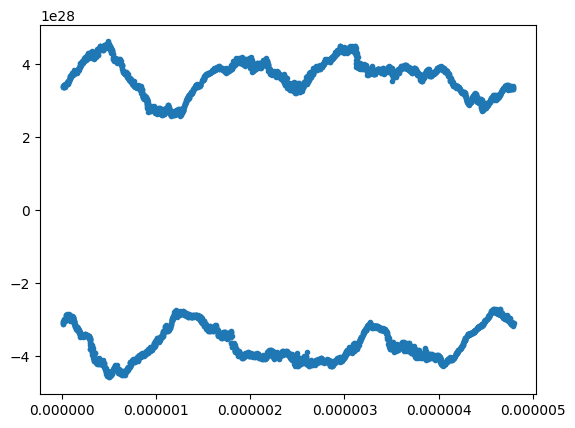

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x146b65e90>

In [160]:
i = 100
plot(px[i,:], vx[i,:], ".")

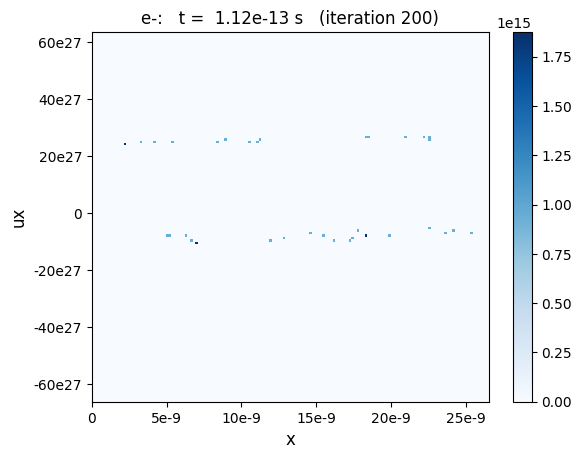

In [163]:
#ts.get_particle(["x", "ux"], species="e- (v+)", iteration=100, plot=true);
ts.get_particle(["x", "ux"], species="e-", iteration=200, plot=true);
